In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dropout,  Input, Layer,Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from pandas_datareader import data

from PyEMD import EMD,EEMD,CEEMDAN,Visualisation

import warnings
warnings.filterwarnings("ignore")

In [2]:
shares_name='CL=F'

In [3]:
start = '2017-01-01'
end = '2019-01-01'
GSPC = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
print(GSPC)
print(GSPC.isnull().sum().sort_values(ascending = False))

GSPC_test = pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])#Choose the data
GSPC_test

            Adj Close
Date                 
2017-01-03  52.330002
2017-01-04  53.259998
2017-01-05  53.759998
2017-01-06  53.990002
2017-01-09  51.959999
...               ...
2018-12-24  42.529999
2018-12-26  46.220001
2018-12-27  44.610001
2018-12-28  45.330002
2018-12-31  45.410000

[502 rows x 1 columns]
Adj Close    0
dtype: int64


,Adj Close
Date,
2017-01-03,52.330002
2017-01-04,53.259998
2017-01-05,53.759998
2017-01-06,53.990002
2017-01-09,51.959999
...,...
2018-12-24,42.529999
2018-12-26,46.220001
2018-12-27,44.610001


In [4]:
start = '2016-01-01'
end = '2019-01-01'
df=pd.DataFrame(data.DataReader(shares_name,"yahoo",start,end)['Adj Close'])
df = df[['Adj Close']]

In [5]:
def create_noisy(data):
    data_noisy = pd.DataFrame()
    for i in range(0,100):
        data_noisy= pd.concat([data_noisy,pd.Series(data.values[:,0])], axis=1)
    return data_noisy.T

In [6]:
def create_pure(data):
    data_pure = pd.DataFrame()
    for i in range(2,52):
        data_pure['SMA{}'.format(i)] = 0
        data_pure['SMA{}'.format(i)] = data[['Adj Close']].rolling(window=i).mean()
    
    data_pure=data_pure.iloc[:,-len(GSPC_noisy.T):]
    data=data.iloc[-len(GSPC_noisy.T):]
    for i in range(2,52):
        data_pure['EMA{}'.format(i)] = 0
        data_pure['EMA{}'.format(i)] = data[['Adj Close']].ewm(span=i, adjust=False).mean()
    
    return data_pure.T

In [7]:
GSPC_noisy=create_noisy(GSPC)

GSPC_pure=create_pure(df).iloc[:,-len(GSPC_noisy.T):]

In [8]:
mm_t_g = MinMaxScaler()
noise_mm = mm_t_g.fit_transform(GSPC_noisy.T).T
prue_mm=mm_t_g.fit_transform(GSPC_pure.T).T
print(prue_mm.shape)
print(noise_mm.shape)

(100, 502)
(100, 502)


In [9]:
X_train_mm = np.asarray(noise_mm)
X_train_mm=X_train_mm.reshape((len(X_train_mm), len(X_train_mm[0]), 1))
Y_train_mm = np.asarray(prue_mm)
Y_train_mm=Y_train_mm.reshape((len(Y_train_mm), len(Y_train_mm[0]), 1))
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=1)

In [10]:
keras.backend.clear_session()

In [11]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform',input_shape=(None, 1)))
    model.add(Conv1D(32, kernel_size=3,activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1DTranspose(32, kernel_size=3, activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1DTranspose(128, kernel_size=3,activation='relu',kernel_constraint=max_norm(2), kernel_initializer='he_uniform'))
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='binary_crossentropy')
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          12320     
                                                                 
 conv1d_transpose (Conv1DTra  (None, None, 32)         3104      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, None, 128)        12416     
 ranspose)                                                       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 1)           385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-traina

In [12]:
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=20, batch_size=10, verbose=0)

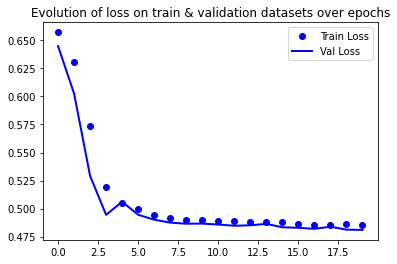

In [13]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']

plt.figure()
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'bo', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'b', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

1/1 [==============================] - 0s 246ms/step


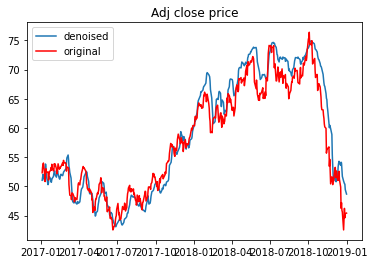

In [14]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(GSPC_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
noise_mm_T=pd.DataFrame(noise_mm_T,columns=['Adj Close'],index=GSPC_test.index)
Y_test_mm_cnn=pd.DataFrame(Y_test_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Adj Close'],index=GSPC_test.index)
plt.figure()
plt.plot(pure_mm_cnn)
plt.plot(GSPC_test,'r')
plt.title('Adj close price')
plt.legend(['denoised', 'original'], loc='upper left')

# regression

In [15]:
original=GSPC_test
recon=pure_mm_cnn

In [16]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['Adj Close'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['Adj Close'].shift(i)
    return ret_dataset

In [17]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import talib
splits=10

29.404860091669324
24.102368196137476
16.35359608951499
16.16542685227632
10.204807774700429
34.389434194854225
11.425122416554098
8.290890398144256
8.630357481608815
100.09308325553245
The last MSE: 100.09308325553245
The average MSE: 25.905994675099237


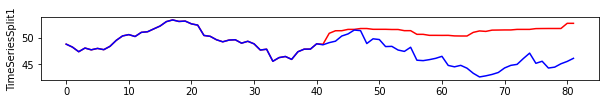

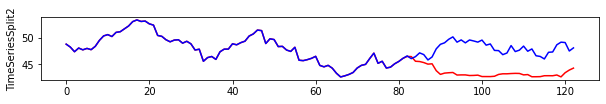

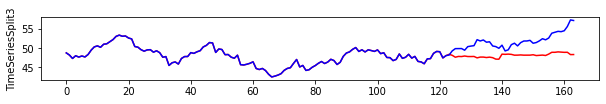

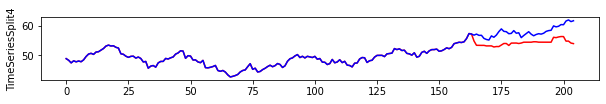

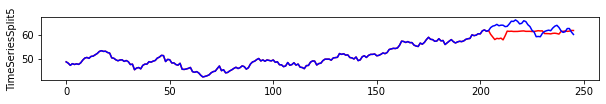

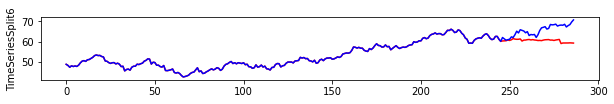

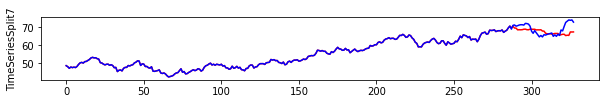

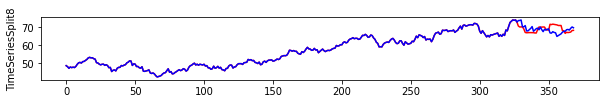

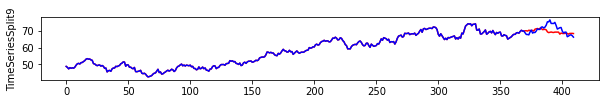

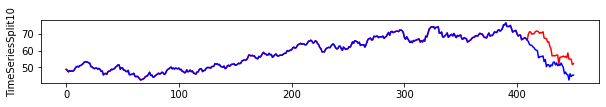

In [18]:
recon_fea=features(recon)
recon_fea=recon_fea.iloc[51:]
original_m=original.iloc[51::]
recon_m=recon.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0

for train_index, test_index in tscv.split(recon_fea):
    model = xgb.XGBRegressor()
    model.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(recon_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [19]:
from bayes_opt import BayesianOptimization
def rf_do(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           #max_delta_step = float(max_delta_step),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(recon_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(recon_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(recon_m.iloc[test_index,:],test_predict)
    return msetest

In [20]:
rf_bo = BayesianOptimization(
        rf_do,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                #'max_delta_step': (0.01,1),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -18.36    |  0.9802   |  0.8663   |  0.05767  |  19.96    |  0.3641   |  539.4    |  0.9731   |  0.6886   |  0.5729   |  0.5526   |
|  2        | -21.29    |  0.9341   |  0.02911  |  0.2154   |  12.69    |  1.283    |  770.4    |  0.8008   |  0.415    |  0.6503   |  0.5361   |
|  3        | -19.13    |  0.9395   |  0.4099   |  0.1113   |  16.43    |  1.747    |  908.2    |  0.6825   |  0.7726   |  0.7734   |  0.5138   |
|  4        | -31.8     |  0.893    |  0.4917   |  0.07502  |  1.949    |  1.715    |  347.0    |  0.3061   |  0.7466   |  0.3531   |  0.9422   |
|  5        | -28.85    |  0.5423   |  0.7352   |  0.1111   |  2.421    |  0.6691   |  315.9    |  0.8163   |  0.7146   |  0

{'target': -14.975397109985352,
 'params': {'colsample_bytree': 0.7440314595675684,
  'gamma': 0.1613484057863267,
  'learning_rate': 0.06734979109185885,
  'max_depth': 18,
  'min_child_weight': 1,
  'n_estimators': 539,
  'reg_alpha': 0.869140129684199,
  'reg_lambda': 0.8558304678020734,
  'scale_pos_weight': 0.8960224370097449,
  'subsample': 0.6702395653841355}}

15.354754476627
4.248217272714189
5.205075706454298
3.523112474569111
4.894593002303027
17.06255339899756
9.807717751315511
2.27578488306892
6.424535790899848
12.354933999041904
The last MSE: 12.354933999041904
The average MSE: 8.115127875599137


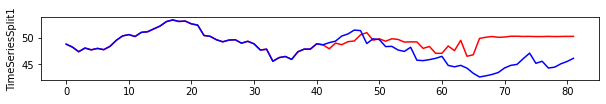

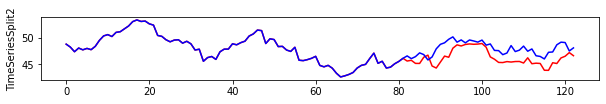

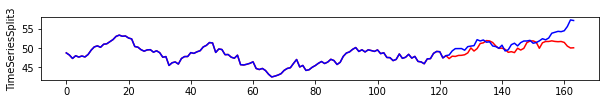

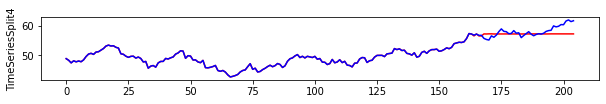

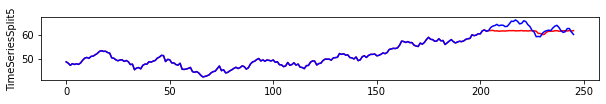

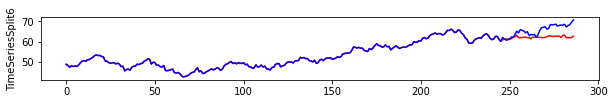

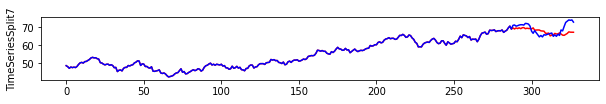

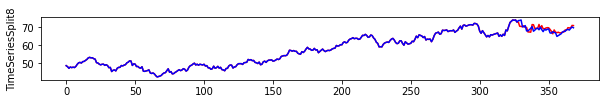

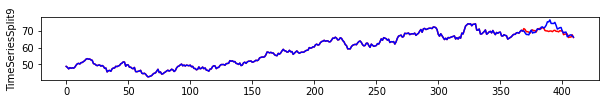

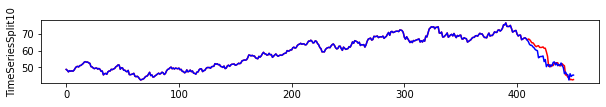

In [21]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
original_m=original.iloc[51::]
tscv = TimeSeriesSplit(n_splits=splits)
msetestav=0
for train_index, test_index in tscv.split(original_fea):
    model = xgb.XGBRegressor()
    model.fit (original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=model.predict(original_fea.iloc[test_index,:])
    msetest=mean_squared_error(original_m.iloc[test_index,:],test_predict)
    i=1+int(len(train_index)/int(len(recon_fea)/splits))
    plt.figure(figsize=(10,15))
    plt.subplot(1 +splits,1,i)
    past=np.asarray(original_m.iloc[train_index,:]).reshape(len(original_m.iloc[train_index,:]))
    whole=np.concatenate((past, test_predict))
    true=np.asarray(original_m.iloc[test_index,:]).reshape(len(original_m.iloc[test_index,:]))
    whole_t=np.concatenate((past, true))
    plt.plot(whole,"r",label='Predicted')
    plt.plot(whole_t,"b",label='Original')
    plt.ylabel('TimeSeriesSplit'+str(i))
    print(msetest)
    msetestav+=msetest
msetestav=msetestav/splits
print('The last MSE:',msetest)
print('The average MSE:',msetestav)

In [22]:
def rf_oo(max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree,reg_alpha,reg_lambda,scale_pos_weight,gamma):
    val = xgb.XGBRegressor(max_depth = round(max_depth),
                           learning_rate = float(learning_rate),
                           n_estimators = round(n_estimators),
                           min_child_weight = round(min_child_weight),
                           subsample = float(subsample),
                           colsample_bytree = float(colsample_bytree),
                           reg_alpha = float(reg_alpha),
                           reg_lambda = float(reg_lambda),
                           scale_pos_weight = float(scale_pos_weight),
                           gamma = float(gamma),
                           eval_metric=mean_squared_error)
    msetest=0
    val.fit(original_fea.iloc[train_index,:],original_m.iloc[train_index,:])
    test_predict=val.predict(original_fea.iloc[test_index,:])
    msetest=-1*mean_squared_error(original_m.iloc[test_index,:],test_predict)
    return msetest

In [23]:
rf_bo = BayesianOptimization(
        rf_oo,
                {'max_depth':(1,20),
                'learning_rate': (0.01,0.3),
                'n_estimators': (100,1000),
                'min_child_weight': (0,2),
                'subsample':(0.5,1),
                'colsample_bytree': (0.5,1),
                'reg_alpha': (0.01,1),
                'reg_lambda': (0.2,1),
                'scale_pos_weight': (0.2,1),
                'gamma':(0,1)}
    )
rf_bo.maximize()#init_points=20, n_iter=10
rf_bo_p=rf_bo.max
rf_bo_p['params']['max_depth'] = round(rf_bo_p['params']['max_depth'])
rf_bo_p['params']['n_estimators'] = round(rf_bo_p['params']['n_estimators'])
rf_bo_p['params']['min_child_weight'] = round(rf_bo_p['params']['min_child_weight'])
rf_bo_p

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -7.071    |  0.5528   |  0.9768   |  0.02366  |  3.383    |  1.826    |  836.9    |  0.3752   |  0.5756   |  0.9917   |  0.6845   |
|  2        | -8.113    |  0.5787   |  0.07872  |  0.2855   |  10.68    |  1.5      |  407.0    |  0.6362   |  0.7658   |  0.5877   |  0.7309   |
|  3        | -8.66     |  0.6106   |  0.3494   |  0.258    |  19.72    |  1.624    |  358.7    |  0.6704   |  0.2268   |  0.4404   |  0.7461   |
|  4        | -8.702    |  0.8813   |  0.9994   |  0.1999   |  14.02    |  0.06594  |  673.7    |  0.3106   |  0.714    |  0.8674   |  0.8626   |
|  5        | -5.477    |  0.9441   |  0.1478   |  0.02497  |  9.53     |  0.6803   |  593.9    |  0.8072   |  0.2393   |  0

{'target': -4.46709149903774,
 'params': {'colsample_bytree': 0.9063271726811682,
  'gamma': 0.11846314275722589,
  'learning_rate': 0.010749403496648564,
  'max_depth': 8,
  'min_child_weight': 1,
  'n_estimators': 571,
  'reg_alpha': 0.7729329399717,
  'reg_lambda': 0.2629047730935775,
  'scale_pos_weight': 0.7670072404392461,
  'subsample': 0.5}}

# EMDCNN

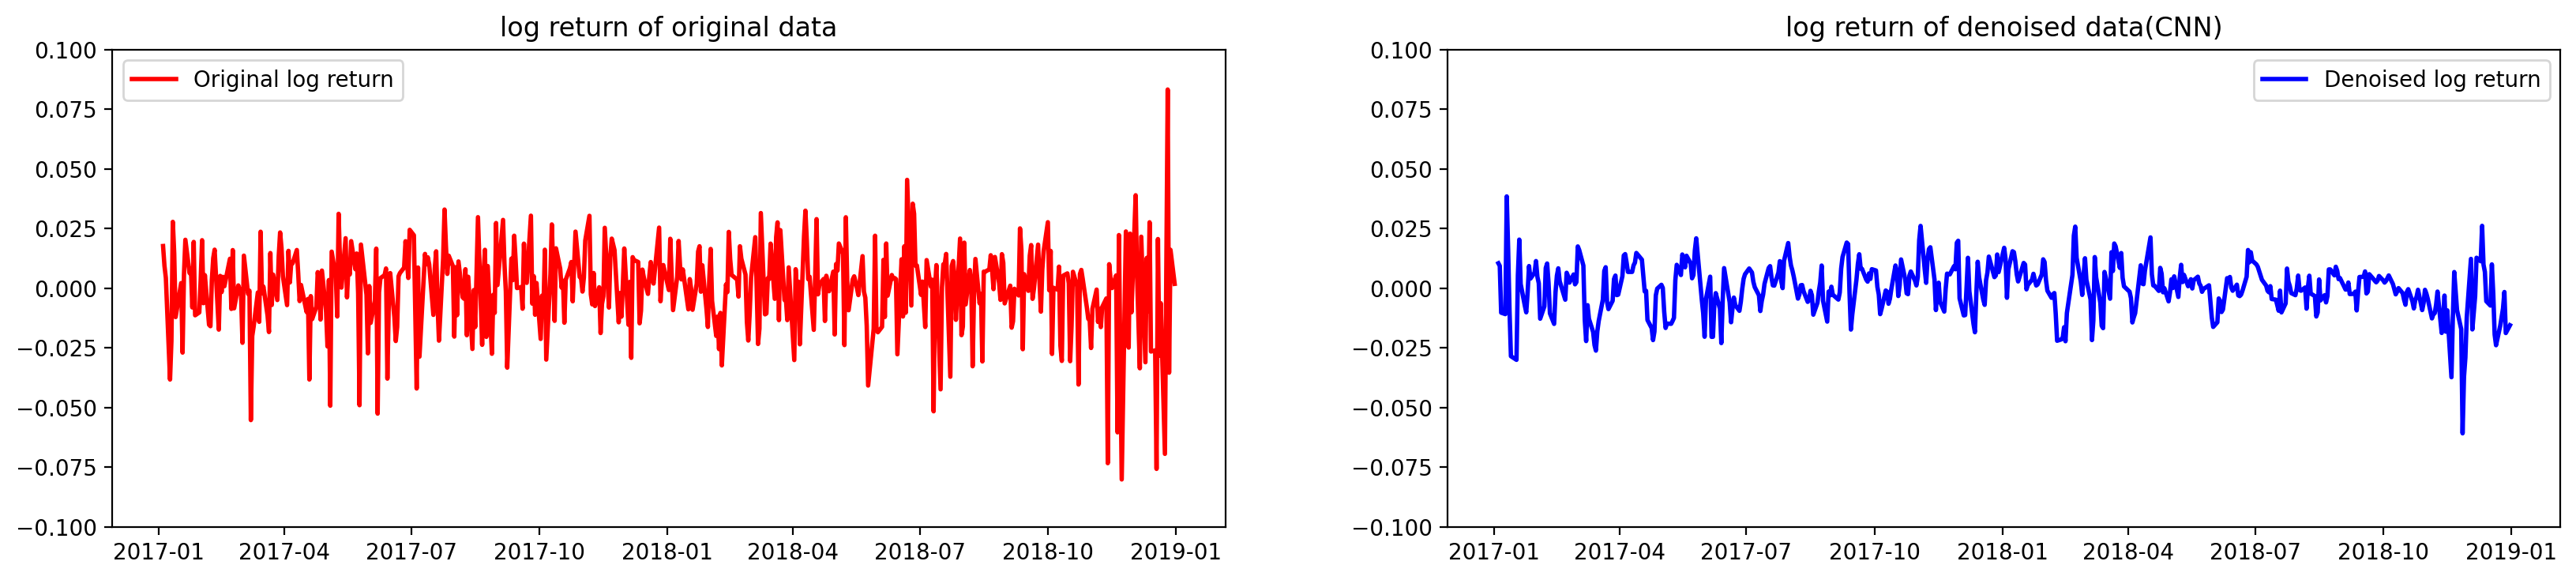

In [24]:
# Log Returns
GSPC_test_n=GSPC_test.copy()
GSPC_test_n['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,2,1)
plt.plot(GSPC_test_n['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.1,0.1)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(pure_mm_cnn['log_ret'] , 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.1,0.1)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')


plt.show()

In [25]:
def svmf1_ori(dataset,dataset2,long_predict=10,percentage=0.8):
    f11=np.empty(0)
    f12=np.empty(0)
    max_t=0
    if dataset['log_ret'].max()>dataset2['log_ret'].max():
        max_t=dataset2['log_ret'].max()
    else:
        max_t=dataset['log_ret'].max()
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        # for dataset
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f11=np.append(f11,f1)
        
        # for dataset2
    for n in np.arange(0.0, (percentage*max_t), (percentage*max_t)/50):#get multiple threshold
        threshold = n
        daily_label2=np.empty(0)#make the data labelled
        for i in range(0,len(dataset2)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label2=np.append(daily_label2,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label2=np.append(daily_label2,n)
            else:
                n=1
                daily_label2=np.append(daily_label2,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset2)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset2.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label2[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=1,shuffle=False)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        model = svc_rbf.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        f1 = f1_score(Y_test,Y_pred,average='weighted')
        f12=np.append(f12,f1)
    return f11,f12

In [26]:
original_svm_ori,denoised_svm_ori=svmf1_ori(GSPC_test_n,pure_mm_cnn,long_predict=1,percentage=1)

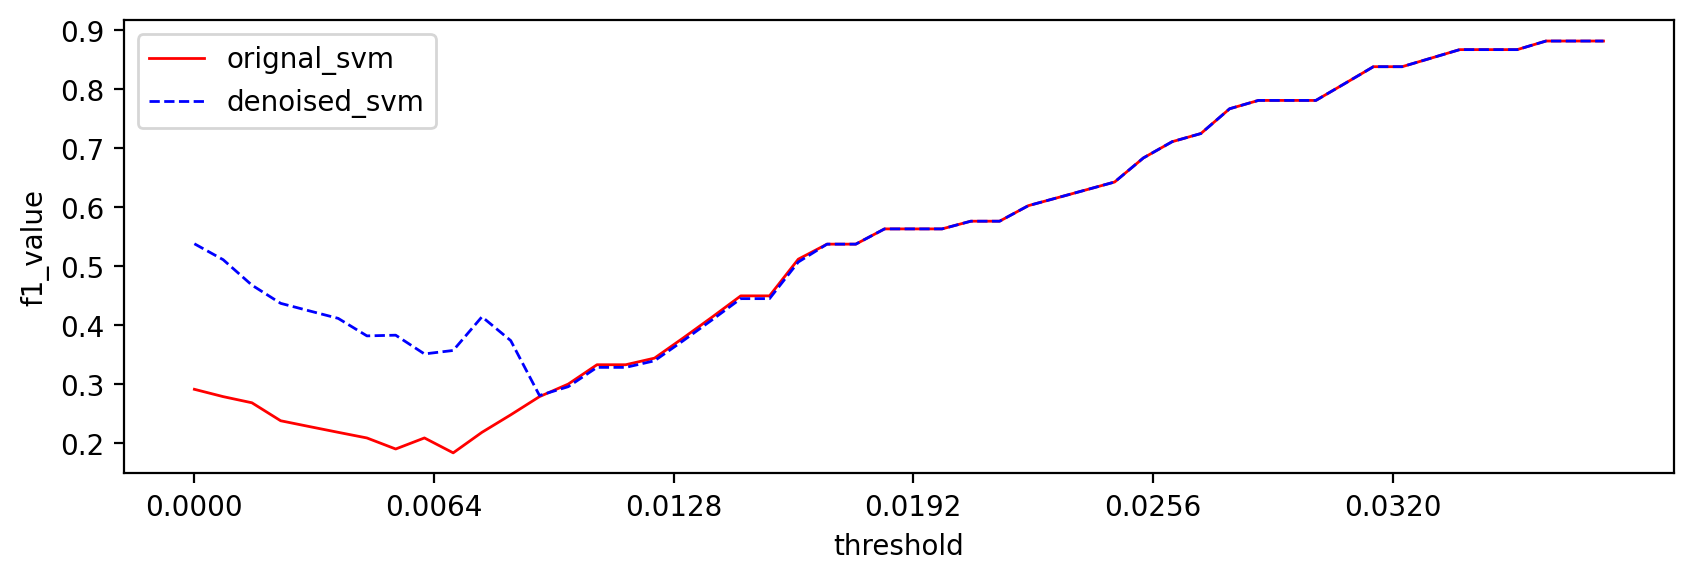

In [27]:
plt.figure(figsize=(10,3),dpi=200)
percentage=1
max_t=0
if GSPC_test_n['log_ret'].max()>pure_mm_cnn['log_ret'].max():
    max_t=pure_mm_cnn['log_ret'].max()
else:
    max_t=GSPC_test_n['log_ret'].max()
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),original_svm_ori,label='orignal_svm', color='red', linewidth=1.0)
plt.plot(np.arange(0.0,(percentage*max_t), (percentage*max_t)/50),denoised_svm_ori,label='denoised_svm', color='blue', linewidth=1.0, linestyle='--')

plt.xticks(np.arange(0.0,(percentage*max_t), (percentage*max_t)/6))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

# Strategies 

## Bollinger band

In [28]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()#.shift(1)
    rolling_std = close_prices.rolling(window,min_periods=1).std()#.shift(1)
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [29]:
def buy_signal_function(dataset):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Adj Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Adj Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,3]):
            buy_signal.iloc[i,4]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,3]):
                buy_signal.iloc[i,5]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,2]):
            buy_signal.iloc[i,4]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,2]):
                buy_signal.iloc[i,5]=-1
    return buy_signal

In [30]:
GSPC_test_signal=buy_signal_function(GSPC_test_n)


pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn)


In [31]:

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')


GSPC_test_signal:
 -1.0    19
 1.0    11
Name: signal, dtype: int64 

pure_mm_cnn_signal:
 -1.0    15
 1.0     8
Name: signal, dtype: int64 



In [32]:
print(GSPC_test[GSPC_test_signal.signal == 1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == 1.0])

            Adj Close
Date                 
2017-03-08  50.279999
2017-05-04  45.520000
2017-06-07  45.720001
2018-02-07  61.790001
2018-05-29  66.730003
2018-06-01  65.809998
2018-08-15  65.010002
2018-10-18  68.650002
2018-10-23  66.430000
2018-11-13  55.689999
2018-12-18  46.240002
            Adj Close
Date                 
2017-03-15  48.860001
2018-02-13  59.189999
2018-06-04  64.750000
2018-08-14  67.040001
2018-10-23  66.430000
2018-10-29  67.040001
2018-11-19  56.759998
2018-11-27  51.560001


In [33]:
print(GSPC_test[GSPC_test_signal.signal == -1.0])
print(GSPC_test[pure_mm_cnn_signal.signal == -1.0])

            Adj Close
Date                 
2017-04-07  52.240002
2017-07-25  47.889999
2017-09-25  52.220001
2017-10-27  53.900002
2017-11-03  55.639999
2017-11-24  58.950001
2017-12-26  59.970001
2017-12-29  60.419998
2018-01-03  61.630001
2018-03-21  65.169998
2018-03-23  65.879997
2018-04-18  68.470001
2018-05-07  70.730003
2018-05-09  71.139999
2018-06-22  68.580002
2018-06-26  70.529999
2018-09-19  71.120003
2018-09-24  72.080002
2018-10-01  75.300003
            Adj Close
Date                 
2017-03-02  52.610001
2017-04-11  53.400002
2017-05-26  49.799999
2017-07-25  47.889999
2017-07-28  49.709999
2017-09-12  48.230000
2017-11-02  54.540001
2017-11-30  57.400002
2018-01-02  60.369999
2018-01-08  61.730000
2018-03-27  65.250000
2018-04-18  68.470001
2018-05-14  70.959999
2018-06-28  73.449997
2018-09-27  72.120003


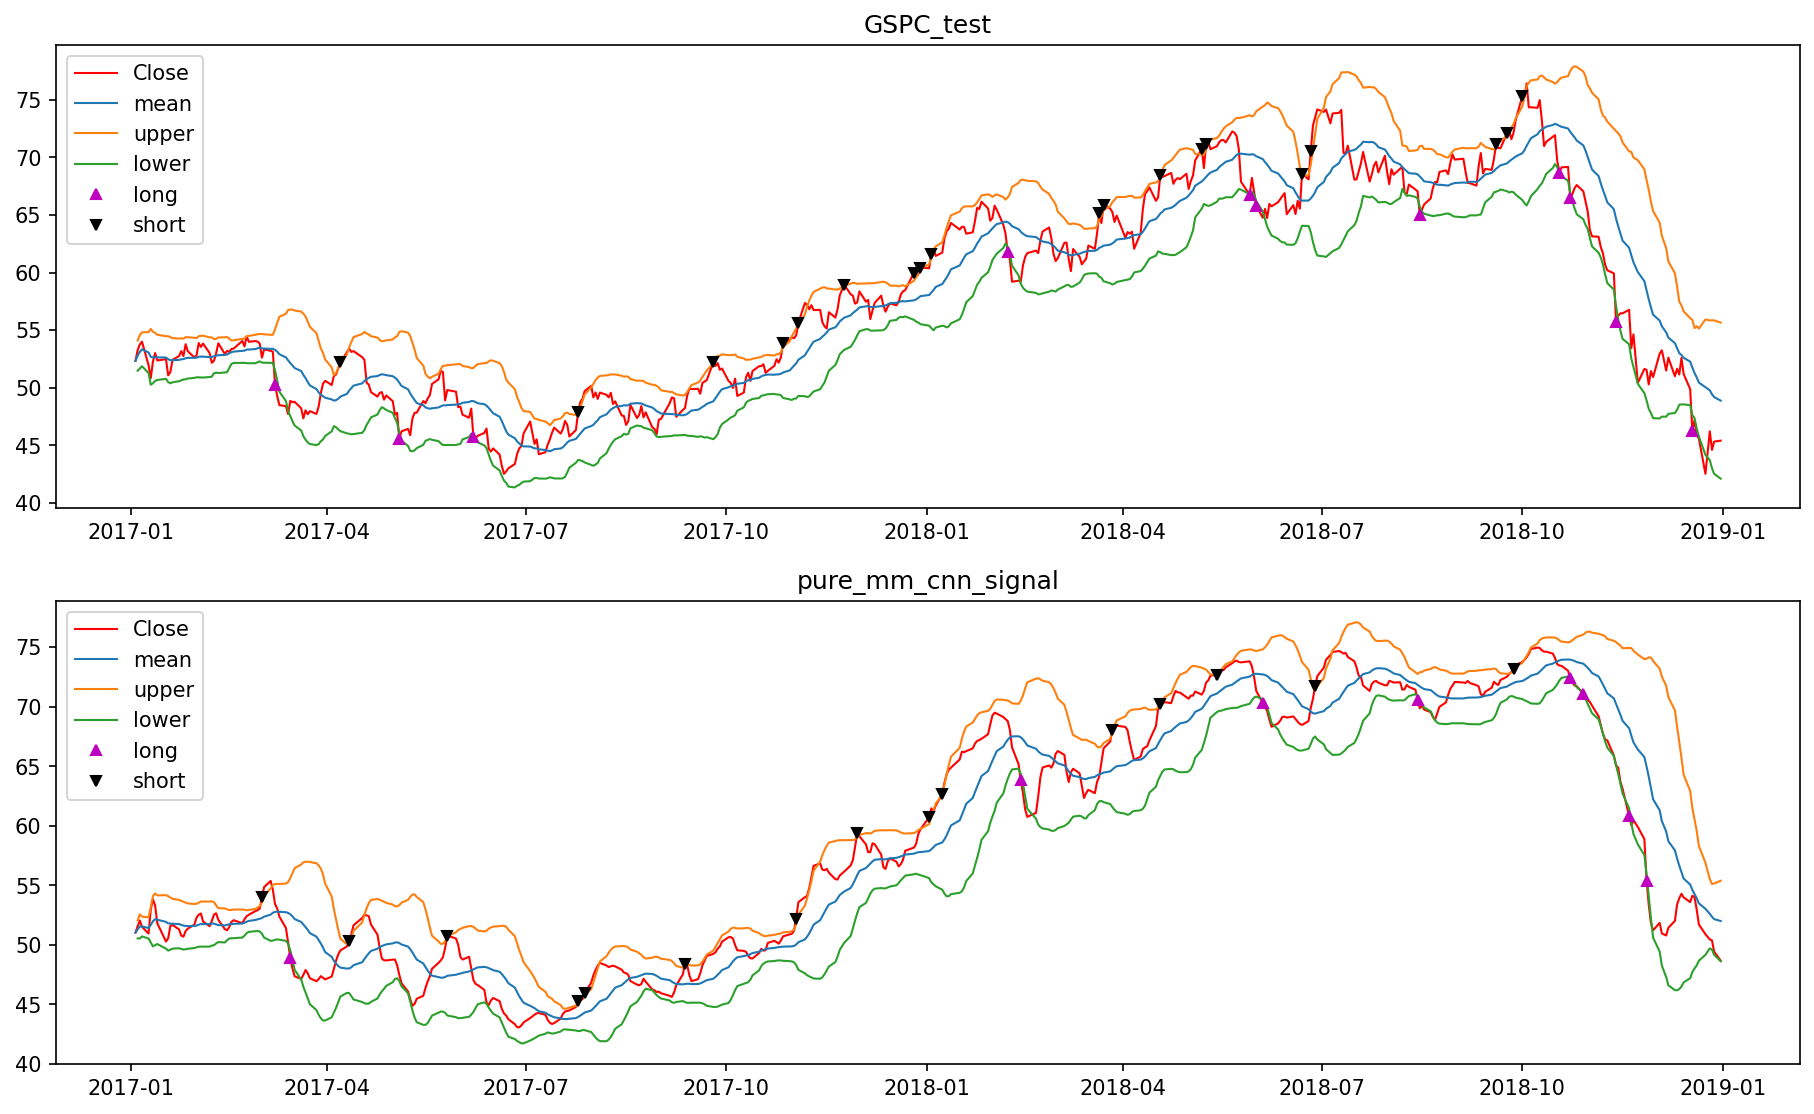

In [34]:
plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_signal['Price'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn_signal')
plt.plot(pure_mm_cnn_signal['Price'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.Price[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()    


## MACD

In [35]:
def MACD(dataset,short_window = 12,long_window = 26, signal_window=9):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term moving averages
    signals['short_mavg'] = dataset['Adj Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term moving averages
    signals['long_mavg'] = dataset['Adj Close'].ewm(span=long_window, min_periods=1).mean()
    
    # Calculate DIF 
    signals['DIF'] = signals['short_mavg']-signals['long_mavg']
    
     # Calculate DIF moving averages
    signals['DEA'] = signals['DIF'].ewm(span=signal_window, min_periods=1).mean()

    # Generate signal
    signals['signal'] = np.where(signals['DIF']> signals['DEA'], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

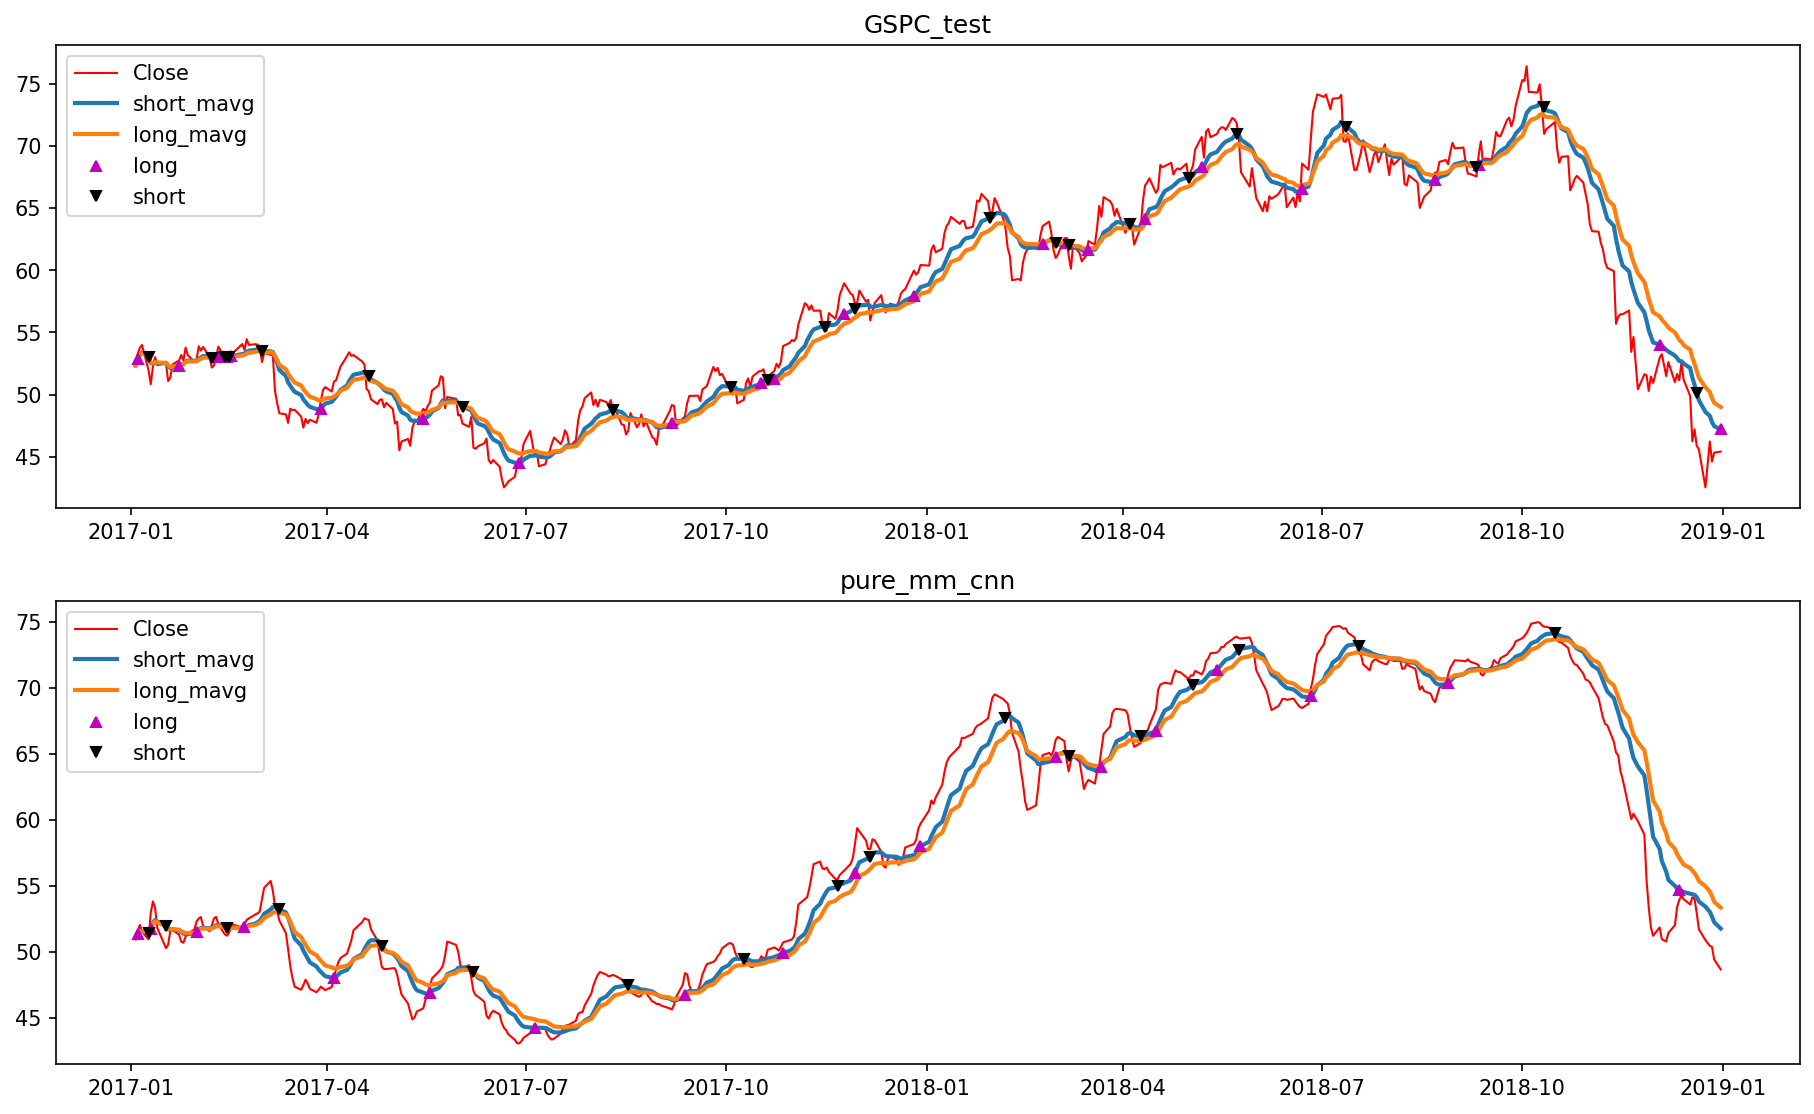

In [36]:
GSPC_test_macd=MACD(GSPC_test_n,short_window = 14,long_window = 22)
pure_mm_cnn_macd=MACD(pure_mm_cnn,short_window = 14,long_window = 22)
#pure_mm_lstm_macd=MACD(pure_mm_lstm,short_window = 14,long_window = 22)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(2,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test_n['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(2,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [37]:
print('GSPC_test_macd:\n',GSPC_test_macd.positions.value_counts(),'\n')
print('pure_mm_cnn_macd:\n',pure_mm_cnn_macd.positions.value_counts(),'\n')

GSPC_test_macd:
  0.0    456
 1.0     23
-1.0     22
Name: positions, dtype: int64 

pure_mm_cnn_macd:
  0.0    466
 1.0     18
-1.0     17
Name: positions, dtype: int64 



In [38]:
print(GSPC_test[GSPC_test_macd['positions']==1])
print(GSPC_test[pure_mm_cnn_macd['positions']==1])

            Adj Close
Date                 
2017-01-04  53.259998
2017-01-23  52.750000
2017-02-10  53.860001
2017-02-14  53.200001
2017-02-16  53.360001
2017-03-29  49.509998
2017-05-15  48.849998
2017-06-28  44.740002
2017-09-06  49.160000
2017-10-17  51.880001
2017-10-23  51.900002
2017-11-24  58.950001
2017-12-26  59.970001
2018-02-23  63.549999
2018-03-06  62.599998
2018-03-16  62.340000
2018-04-11  66.820000
2018-05-07  70.730003
2018-06-22  68.580002
2018-08-22  67.860001
2018-09-11  69.250000
2018-12-03  52.950001
2018-12-31  45.410000
            Adj Close
Date                 
2017-01-04  53.259998
2017-01-10  50.820000
2017-01-31  52.810001
2017-02-22  53.590000
2017-04-04  51.029999
2017-05-18  49.349998
2017-07-05  45.130001
2017-09-12  48.230000
2017-10-27  53.900002
2017-11-29  57.299999
2017-12-29  60.419998
2018-03-01  60.990002
2018-03-22  64.300003
2018-04-16  66.220001
2018-05-14  70.959999
2018-06-26  70.529999
2018-08-28  68.529999
2018-12-12  51.150002


In [39]:
print(GSPC_test[GSPC_test_macd['positions']==-1])
print(GSPC_test[pure_mm_cnn_macd['positions']==-1])

            Adj Close
Date                 
2017-01-09  51.959999
2017-02-07  52.169998
2017-02-13  52.930000
2017-02-15  53.110001
2017-03-02  52.610001
2017-04-20  50.270000
2017-06-02  47.660000
2017-08-10  48.590000
2017-10-03  50.419998
2017-10-20  51.470001
2017-11-15  55.330002
2017-11-29  57.299999
2018-01-30  64.500000
2018-03-01  60.990002
2018-03-07  61.150002
2018-04-04  63.369999
2018-05-01  67.250000
2018-05-23  71.839996
2018-07-12  70.330002
2018-09-10  67.540001
2018-10-11  70.970001
2018-12-20  45.880001
            Adj Close
Date                 
2017-01-09  51.959999
2017-01-17  52.480000
2017-02-14  53.200001
2017-03-10  48.490002
2017-04-26  49.619999
2017-06-07  45.720001
2017-08-17  47.090000
2017-10-09  49.580002
2017-11-21  56.830002
2017-12-06  55.959999
2018-02-06  63.389999
2018-03-07  61.150002
2018-04-09  63.419998
2018-05-03  68.430000
2018-05-24  70.709999
2018-07-18  68.760002
2018-10-16  71.919998


## MA

In [40]:
def MA(dataset,short_window = 10,long_window = 50):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Adj Close'].rolling(window=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

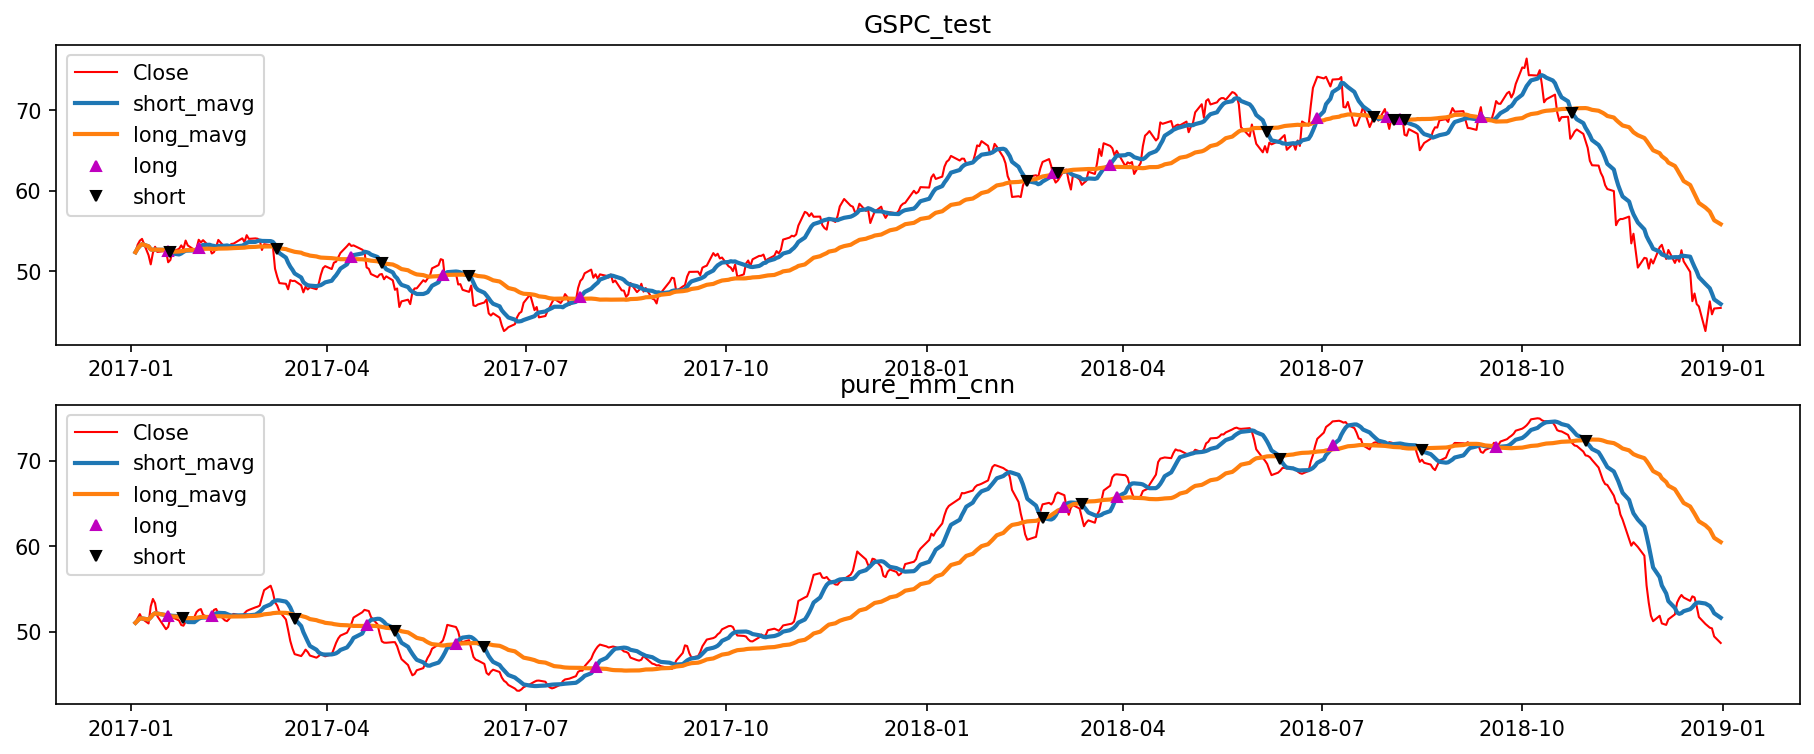

In [41]:
GSPC_test_ma=MA(GSPC_test,short_window = 10,long_window = 50)
pure_mm_cnn_ma=MA(pure_mm_cnn,short_window = 10,long_window = 50)
#pure_mm_lstm_ma=MA(pure_mm_lstm,short_window = 10,long_window = 50)

plt.figure(figsize=(15,9),dpi=150)
plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Adj Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == 1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(GSPC_test_ma.loc[GSPC_test_ma.positions == -1.0].index, 
         GSPC_test_ma.short_mavg[GSPC_test_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Adj Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_ma[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == 1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == 1.0],
         '^', markersize=5, color='m',label='long')
plt.plot(pure_mm_cnn_ma.loc[pure_mm_cnn_ma.positions == -1.0].index, 
         pure_mm_cnn_ma.short_mavg[pure_mm_cnn_ma.positions == -1.0],
         'v', markersize=5, color='k',label='short')
plt.legend()   



In [42]:
print('GSPC_test_ma:\n',GSPC_test_ma.positions.value_counts(),'\n')
print('pure_mm_cnn_ma:\n',pure_mm_cnn_ma.positions.value_counts(),'\n')

GSPC_test_ma:
  0.0    479
 1.0     11
-1.0     11
Name: positions, dtype: int64 

pure_mm_cnn_ma:
  0.0    483
 1.0      9
-1.0      9
Name: positions, dtype: int64 



In [43]:
print(GSPC_test[GSPC_test_ma['positions']==1])
print(GSPC_test[pure_mm_cnn_ma['positions']==1])

            Adj Close
Date                 
2017-01-18  51.080002
2017-02-01  53.880001
2017-04-12  53.110001
2017-05-24  51.360001
2017-07-26  48.750000
2018-02-28  61.639999
2018-03-26  65.550003
2018-06-29  74.150002
2018-07-31  68.760002
2018-08-06  69.010002
2018-09-12  70.370003
            Adj Close
Date                 
2017-01-18  51.080002
2017-02-07  52.169998
2017-04-19  50.439999
2017-05-30  49.660000
2017-08-02  49.590000
2018-03-05  62.570000
2018-03-29  64.940002
2018-07-06  73.800003
2018-09-19  71.120003


In [44]:
print(GSPC_test[GSPC_test_ma['positions']==-1])
print(GSPC_test[pure_mm_cnn_ma['positions']==-1])

            Adj Close
Date                 
2017-01-19  51.369999
2017-03-09  49.279999
2017-04-26  49.619999
2017-06-05  47.400002
2018-02-16  61.680000
2018-03-02  61.250000
2018-06-06  64.730003
2018-07-25  69.300003
2018-08-03  68.489998
2018-08-08  66.940002
2018-10-24  66.820000
            Adj Close
Date                 
2017-01-25  52.750000
2017-03-17  48.779999
2017-05-02  47.660000
2017-06-12  46.080002
2018-02-23  63.549999
2018-03-13  60.709999
2018-06-12  66.360001
2018-08-16  65.459999
2018-10-30  66.180000


## Strategies backtest

In [45]:
def combinesig(dataset,dataset1,dataset2,dataset3):    
    dataset_backtesting=pd.DataFrame()
    dataset_backtesting['Adj Close']=dataset['Adj Close']
    dataset_backtesting['masig']=dataset1['positions']
    dataset_backtesting['macdsig']=dataset2['positions']
    dataset_backtesting['bbsig']=dataset3['signal']
    return dataset_backtesting

In [46]:
GSPC_backtesting=combinesig(GSPC_test,GSPC_test_ma,GSPC_test_macd,GSPC_test_signal)
pure_mm_cnn_backtesting=combinesig(GSPC_test,pure_mm_cnn_ma,pure_mm_cnn_macd,pure_mm_cnn_signal)


In [47]:
def backtest(dataset,asset=1e8, signal=''):
    share_number = 0
    cash = asset
    for i in range(len(dataset)):
        if dataset[signal][i]==1:
            share_number=share_number+cash//(100*dataset['Adj Close'][i])*100
            if cash//(100*dataset['Adj Close'][i])*100>0:
                cash=cash-cash//(100*dataset['Adj Close'][i])*100*dataset['Adj Close'][i]
        elif dataset[signal][i]==-1:
            cash=cash+share_number*dataset['Adj Close'][i]
            share_number=0
    asset_now=cash+share_number*dataset['Adj Close'][i]
    return_value=(asset_now-asset)/asset
    return return_value

In [48]:
mareturn=backtest(GSPC_backtesting,signal='masig')
mareturn_cnn=backtest(pure_mm_cnn_backtesting,signal='masig')
print(mareturn)
print(mareturn_cnn)


-0.15571207510757445
-0.1121317204208374


In [49]:
macdreturn=backtest(GSPC_backtesting,signal='macdsig')
macdreturn_cnn=backtest(pure_mm_cnn_backtesting,signal='macdsig')
#mareturn_lstm=backtest(pure_mm_lstm_backtesting,signal='macdsig')
print(macdreturn)
print(macdreturn_cnn)
#print(mareturn_lstm)

0.0054119971199035645
-0.11333330701065064


In [50]:
bbreturn=backtest(GSPC_backtesting,signal='bbsig')
bbreturn_cnn=backtest(pure_mm_cnn_backtesting,signal='bbsig')
print(bbreturn)
print(bbreturn_cnn)


-0.1426135922355652
0.005034634506225586
